# Time Series Regression - $LiOH$

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
import requests
import io

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
import statsmodels.tsa.arima.model as tsa
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

from dataloader import YahooDownloader

mining_list = {
    'AKE.AX': ['Allkem Limited'], # AKE.TO, 0TWH.L; MIDSTREAM(Refinery)
    'LAC': ['Lithium Americas'], # LAC.TO
    '002497.SZ': ['Sichuan Yahua Group'], 
    'LTHM': ["Livent Corp"],
    'MIN.AX': ['Mineral Resources Limited'], 
    'PLS.AX': ['Pilbara Minerals'], 
    '002176.SZ': ['Jiangxi Special Electric Motor'], # MIDSTREAM(Refinery)
    'SYA.AX': ['Sayona Mining Limited'], # Morella Corporation Earn-in Agreement
    'LTUM': ['Lithium Corporation'], # Morella Corporation Earn-in Agreement
    'CRE.V': ['Critical Elements Lithium Corporation'], 
    'ERA.PA': ['Eramet S.A.'], # MIDSTREAM
    'INF.AX': ['Infinity Lithium Corporation Limited'], # 3PM.F 
    'LITH.V': ['Lithium Chile Inc.'], 
    'LIS.V': ['Lithium South Development Corporation'],  
    'LEL.AX': ['Lithium Energy Limited'], 
    'QMC.V': ['QMC Quantum Minerals Corp.'], # 3LQ.F
    'SGML': ['Sigma Lithium Resources Corporation'], # SGML.V
    '002460.SZ': ['Ganfeng Lithium'], # 1772.HK
    '002466.SZ': ['Tianqi Lithium'], # 9696.HK
    'LPI.AX': ['Lithium Power International'],
    'LTH.V': ['Lithium Ionic Corp'], # 
    'AMLI': ['American Lithium'], # LI.V
    'WML.V': ['Wealth Minerals Ltd'], # EJZN.F
    'ALB': ["Albemarle"], # Refinery
    'SQM': ['Sociedad Química y Minera de Chile S.A.'], # Refinery
    'A11.AX': ['Atlantic Lithium'], # ALL.L
    'SLI': ["standard lithium"], # Refinery
}

In [3]:
def transform_data(file_path, sampling_period = 'W-FRI'): 
    
    '''
    This function transform the price into log return and output the weekly log return and price in a dataframe.
    '''

    outlier_cutoff = 0.01
    # read the data
    price = pd.read_csv(file_path)

    # print or inspect the DataFrame before renaming the columns
    print(price.head())

    # ask for the column names 
    column_names = input("Please enter the column names, separated by a comma: ").split(',')

    # strip any leading/trailing whitespace from the column names
    column_names = [name.strip() for name in column_names]

    # rename the columns 
    price.columns = column_names

    # transfer the date to date format 
    price['Date'] = pd.to_datetime(price['Date'])
    
    if (price['Price'].apply(type) == str).any():
        price['Price'] = price['Price'].str.replace(',', '', regex=True).astype(float)
    price.set_index('Date', inplace=True)

    # Resample to get the last business day's 'Close' price for each week.
    # 'W-FRI' denotes weeks ending on Friday.
    weekly_price = price['Price'].resample(sampling_period).last()

    # make the series a dataframe:
    weekly_price = pd.DataFrame(weekly_price)

    # Calculate log returns
    weekly_price['Log_Return'] = np.log(weekly_price["Price"]).diff().\
    pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))

    # The first entry will be NaN because there's no previous data to calculate a return from.
    # So, we remove the first entry
    weekly_price = weekly_price.dropna()

    return weekly_price

def plot_correlogram(x, lags=None, title=None):
    '''
    Plot the series, QQ plot, ACF, PACF
    '''
    lags = min(10, int(len(x)/5)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Series(residuals)')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        probplot(x, plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        
        plot_acf(x=x, lags=lags, ax=axes[1][0])
        plot_pacf(x, lags=lags, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)
        
def ARIMA_Model_Fit(series, p,d,q, title):
    '''
    Fit the ARIMA model and output the residual of the model 
    '''
    plot_correlogram(series, lags = 50, title = "Before Modeling: " + title)
    model_price = tsa.ARIMA(series,order=(p,d,q)).fit()
    print(model_price.summary())
    plot_correlogram(model_price.resid, lags = 50, title = "After Modeling: "+ title)
    return model_price.resid

def get_data(start_date, end_date, ticker):
    if ticker.endswith('.US'):
        ticker = ticker.split('.')[0]
    downloader = YahooDownloader(start_date = start_date, end_date = end_date, ticker_list=[ticker])
    data = downloader.fetch_data()
    df = data[['date', 'close']].copy()
    df.columns = ['Date', 'Price']
    return df

def get_stock_data(ticker, start_date, end_date, sampling_period = 'W-FRI'):
    df = get_data(start_date, end_date, ticker)
    df['Date'] = pd.to_datetime(df['Date'])
    df.columns = ['Date',"Asset_close"]

    df.set_index('Date', inplace=True)
    # Resample to get the last business day's 'Close' price for each week.
    # 'W-FRI' denotes weeks ending on Friday.
    weekly_df = df['Asset_close'].resample(sampling_period).last()

    weekly_df = pd.DataFrame(weekly_df)
    weekly_df['Log_Return'] = np.log(weekly_df["Asset_close"]).diff()

    # The first entry will be NaN because there's no previous data to calculate a return from.
    # So, we remove the first entry
    weekly_df = weekly_df.dropna()
    return weekly_df

## Weekly Lithium Carbonate Price

In [4]:
weekly_lioh_price = transform_data("../Data/Lithium Hydroxide (wind database).csv")

         Date  LiOH 56.5%
0  2005-01-04       27000
1  2005-01-05       27000
2  2005-01-06       27000
3  2005-01-07       27000
4  2005-01-10       27000


Please enter the column names, separated by a comma:  Date, Price


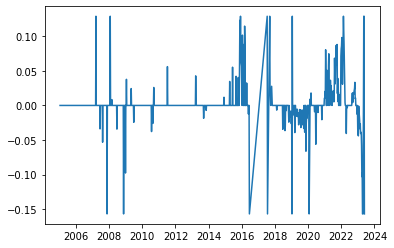

In [6]:
plt.plot(weekly_lioh_price.Log_Return)

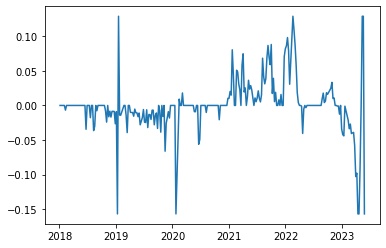

In [9]:
plt.plot(weekly_lioh_price[weekly_lioh_price.index>'2018'].Log_Return)

## Part 1)

In [10]:
target_df = weekly_lioh_price.copy()
ticker = "LPI.AX"

def individual_company_concur(target_df, ticker):
    stock_data = get_stock_data(ticker, start_date = '2017-09-08', end_date = '2023-08-07', sampling_period = 'W-FRI')
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Price', 'Li_LogReturn', "Asset", "Assest_LogReturn"]
    
    model = smf.ols('Li_LogReturn~ Assest_LogReturn', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'coefficient' : model.params['Assest_LogReturn'],
    'coefficient_pvalue' : model.pvalues['Assest_LogReturn'],
    'hac_standard_error' : model.bse['Assest_LogReturn']}
    
    return res

In [11]:
target_df = weekly_lioh_price.copy()

result1 = []

for ticker in mining_list.keys():
    try:
        res = individual_company_concur(target_df, ticker)
    except Exception as e:
        res = {}
    res['ticker'] = ticker
    result1.append(res)
df_result1 = pd.DataFrame(result1)
df_result1.set_index('ticker', inplace=True)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1211, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1483, 8)


In [12]:
df_result1

,intercept,intercept_pvalue,coefficient,coefficient_pvalue,hac_standard_error
ticker,,,,,
AKE.AX,0.00,0.83,0.04,0.17,0.03
LAC,0.00,0.82,0.02,0.13,0.01
002497.SZ,0.00,0.78,0.05,0.09,0.03
LTHM,0.00,0.75,0.01,0.63,0.02
MIN.AX,0.00,0.79,-0.00,0.93,0.05
PLS.AX,0.00,0.87,0.04,0.09,0.02
002176.SZ,0.00,0.78,0.08,0.01,0.03
SYA.AX,0.00,0.84,0.02,0.03,0.01
LTUM,0.00,0.79,-0.01,0.35,0.01


## Part 2) 

In [18]:
# Calculate moving averages for various lags
def individual_company_lag(target_df, ticker, lag):
    stock_data = get_stock_data(ticker, start_date = '2017-09-08', end_date = '2023-08-07', sampling_period = 'W-FRI')
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Price', 'Li_LogReturn', "Asset", "Asset_LogReturn"]
    merged_df['Asset_Lag'] = merged_df['Asset_LogReturn'].rolling(window = lag).mean().shift(1)
    model = smf.ols('Li_LogReturn~ Asset_Lag', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'lag_coefficient' : model.params['Asset_Lag'],
    'lag_coefficient_pvalue' : model.pvalues['Asset_Lag'],
    'hac_standard_error' : model.bse['Asset_Lag']}
    
    return res


In [19]:
target_df = weekly_lioh_price.copy()

result = []

for ticker in mining_list.keys():
    for lag in range(1,5):
        try:
            res = individual_company_lag(target_df, ticker, lag = lag)
        except Exception as e:
            res = {}
        res['ticker'] = ticker
        res['lag'] = lag
        result.append(res)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)


In [20]:
df_result2 = pd.DataFrame(result)
df_result2.set_index(['ticker', 'lag'])

intercept  intercept_pvalue  lag_coefficient  \
ticker lag                                                 
AKE.AX 1         0.00              0.86             0.04   
       2         0.00              0.84             0.02   
       3         0.00              0.88             0.05   
       4         0.00              0.91             0.07   
LAC    1         0.00              0.83             0.01   
...               ...               ...              ...   
A11.AX 4        -0.03              0.04             0.25   
SLI    1         0.00              0.87             0.02   
       2         0.00              0.87             0.01   
       3         0.00              0.87             0.02   
       4         0.00              0.87             0.02   

            lag_coefficient_pvalue  hac_standard_error  
ticker lag                                              
AKE.AX 1                      0.09                0.03  
       2                      0.69                0.05  
       3                      0.46                0.07  
       4                      0.37                0.07  
LAC    1                      0.43                0.01  
...                            ...                 ...  
A11.AX 4                      0.22                0.20  
SLI    1                      0.33                0.02  
       2                      0.60                0.03  
       3                      0.70                0.04  
       4                      0.73                0.05  

[108 rows x 5 columns]

## Part3) 

In [21]:
target_df = weekly_lioh_price.copy()
ticker = "LPI.AX"

def individual_company_concur_lag1(target_df, ticker):
    stock_data = get_stock_data(ticker, start_date = '2017-09-08', end_date = '2023-08-07', sampling_period = 'W-FRI')
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Price', 'Li_LogReturn', "Asset", "Assest_LogReturn"]
    merged_df['Lithium_lag1'] = merged_df['Li_LogReturn'].shift(1)
    model = smf.ols('Li_LogReturn~ Assest_LogReturn + Lithium_lag1', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'asset_coefficient' : model.params['Assest_LogReturn'],
    'asset_coefficient_pvalue' : model.pvalues['Assest_LogReturn'],
    'asset_hac_standard_error' : model.bse['Assest_LogReturn'],
    'lithium_lag1_coefficient' : model.params['Lithium_lag1'],
    'lithium_lag1_coefficient_pvalue' : model.pvalues['Lithium_lag1'],
    'lithium_lag1_hac_standard_error' : model.bse['Lithium_lag1']}
    
    return res

In [22]:
target_df = weekly_lioh_price.copy()

result3_1 = []

for ticker in mining_list.keys():
    try:
        res = individual_company_concur_lag1(target_df, ticker)
    except Exception as e:
        res = {}
    res['ticker'] = ticker
    result3_1.append(res)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1211, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1483, 8)


In [23]:
df_result3_1 = pd.DataFrame(result3_1)
df_result3_1.set_index(["ticker"])

,intercept,intercept_pvalue,asset_coefficient,asset_coefficient_pvalue,asset_hac_standard_error,lithium_lag1_coefficient,lithium_lag1_coefficient_pvalue,lithium_lag1_hac_standard_error
ticker,,,,,,,,
AKE.AX,-0.00,0.96,0.04,0.13,0.02,0.51,0.00,0.16
LAC,-0.00,0.98,0.03,0.04,0.01,0.51,0.00,0.16
002497.SZ,0.00,0.95,0.05,0.03,0.02,0.51,0.00,0.16
LTHM,0.00,0.91,0.02,0.30,0.02,0.52,0.00,0.16
MIN.AX,-0.00,1.00,0.02,0.68,0.04,0.51,0.00,0.16
PLS.AX,-0.00,0.91,0.04,0.05,0.02,0.51,0.00,0.16
002176.SZ,0.00,0.95,0.07,0.01,0.03,0.50,0.00,0.16
SYA.AX,-0.00,0.98,0.01,0.21,0.01,0.51,0.00,0.16
LTUM,0.00,0.98,0.00,0.58,0.01,0.51,0.00,0.16


In [24]:
def individual_company_lag_lag1(target_df, ticker, lag):
    stock_data = get_stock_data(ticker, start_date = '2017-09-08', end_date = '2023-08-07', sampling_period = 'W-FRI')
    merged_df = target_df.merge(stock_data, how='left', left_index=True, right_index=True).dropna()
    merged_df.columns = ['Price', 'Li_LogReturn', "Asset", "Asset_LogReturn"]
    merged_df['Lithium_lag1'] = merged_df['Li_LogReturn'].shift(1)
    merged_df['Asset_Lag'] = merged_df['Asset_LogReturn'].rolling(window = lag).mean().shift(1)
    model = smf.ols('Li_LogReturn~ Asset_Lag + Lithium_lag1', data=merged_df).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

    # Extract the slope coefficient and its HAC standard error
    res = {'intercept':model.params['Intercept'],
    'intercept_pvalue' : model.pvalues['Intercept'],
    'asset_lag_coefficient' : model.params['Asset_Lag'],
    'asset_lag_coefficient_pvalue' : model.pvalues['Asset_Lag'],
    'asset_lag_hac_standard_error' : model.bse['Asset_Lag'],
    'lithium_lag1_coefficient' : model.params['Lithium_lag1'],
    'lithium_lag1_coefficient_pvalue' : model.pvalues['Lithium_lag1'],
    'lithium_lag1_hac_standard_error' : model.bse['Lithium_lag1']}
    
    return res

In [25]:
target_df = weekly_lioh_price.copy()

result3_2 = []

for ticker in mining_list.keys():
    for lag in range(1,5):
        try:
            res = individual_company_lag_lag1(target_df, ticker, lag = lag)
        except Exception as e:
            res = {}
        res['ticker'] = ticker
        res['lag'] = lag
        result3_2.append(res)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1494, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1486, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1432, 8)


In [26]:
df_result3_2 = pd.DataFrame(result3_2)
df_result3_2.set_index(['ticker', 'lag'])

intercept  intercept_pvalue  asset_lag_coefficient  \
ticker lag                                                       
AKE.AX 1        -0.00              0.97                   0.03   
       2         0.00              0.94                  -0.02   
       3         0.00              1.00                   0.02   
       4        -0.00              0.97                   0.01   
LAC    1         0.00              0.98                   0.00   
...               ...               ...                    ...   
A11.AX 4        -0.02              0.15                   0.23   
SLI    1        -0.00              1.00                   0.01   
       2         0.00              0.99                  -0.00   
       3         0.00              0.99                  -0.00   
       4         0.00              1.00                   0.00   

            asset_lag_coefficient_pvalue  asset_lag_hac_standard_error  \
ticker lag                                                               
AKE.AX 1                            0.16                          0.02   
       2                            0.61                          0.04   
       3                            0.77                          0.06   
       4                            0.79                          0.05   
LAC    1                            0.78                          0.01   
...                                  ...                           ...   
A11.AX 4                            0.07                          0.13   
SLI    1                            0.52                          0.01   
       2                            0.97                          0.02   
       3                            0.98                          0.03   
       4                            0.94                          0.04   

            lithium_lag1_coefficient  lithium_lag1_coefficient_pvalue  \
ticker lag                                                              
AKE.AX 1                        0.51                             0.00   
       2                        0.51                             0.00   
       3                        0.51                             0.00   
       4                        0.51                             0.00   
LAC    1                        0.51                             0.00   
...                              ...                              ...   
A11.AX 4                        0.49                             0.06   
SLI    1                        0.51                             0.00   
       2                        0.51                             0.00   
       3                        0.51                             0.00   
       4                        0.51                             0.00   

            lithium_lag1_hac_standard_error  
ticker lag                                   
AKE.AX 1                               0.16  
       2                               0.16  
       3                               0.16  
       4                               0.16  
LAC    1                               0.16  
...                                     ...  
A11.AX 4                               0.27  
SLI    1                               0.16  
       2                               0.16  
       3                               0.16  
       4                               0.16  

[108 rows x 8 columns]